In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
# __

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score

# fast __
import torch

In [2]:
#pip install xgboost

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Graphique model:", device)

Graphique model: cuda


In [4]:
df = pd.read_csv("housing_risk.csv")

In [5]:
df

,Unnamed: 0,Serial Number,List Year,Transaction Date,Town,Address,Assessed Value,Sale Amount,Sales Ratio,Property Type,...,Year,Unemployment Rate,Mortgage Value,avg_volatility_by_town,Unemployment_scaled,Mortgage_scaled,Volatility_scaled,risk_score,risk_score_scaled,risk_category
0,0,220008,2022,2023-01-30,Andover,618 ROUTE 6,139020.0,232000.0,1.668825,Residential,...,2023.0,3.208333,342.758333,1.416452e+05,-1.385572,-1.281173,-0.639494,56761.868207,-1.055821,Safe
1,1,2020348,2020,2021-09-13,Ansonia,230 WAKELEE AVE,150500.0,325000.0,2.159468,Commercial,...,2021.0,6.475000,851.511667,1.922503e+05,0.499992,1.310962,-0.596558,77157.525100,0.304663,Neutral
2,2,20002,2020,2020-10-02,Ashford,390 TURNPIKE RD,253000.0,430000.0,1.699605,Residential,...,2020.0,7.983333,717.053333,2.692246e+05,1.370622,0.625887,-0.531250,107907.351323,0.386453,Neutral
3,3,210317,2021,2022-07-05,Avon,53 COTSWOLD WAY,329730.0,805000.0,2.441391,Residential,...,2022.0,4.050000,523.630000,6.995574e+05,-0.899750,-0.359619,-0.166135,279981.258884,-0.444265,Neutral
4,4,200212,2020,2021-03-09,Avon,5 CHESTNUT DRIVE,130400.0,179900.0,1.379601,Residential,...,2021.0,6.475000,851.511667,6.995574e+05,0.499992,1.310962,-0.166135,280080.350884,0.476832,Neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1097624,1097624,190272,2019,2020-06-24,New London,4 BISHOP CT,60410.0,53100.0,0.878994,Single Family,...,2020.0,7.983333,717.053333,6.840540e+05,1.370622,0.625887,-0.179289,273839.117093,0.527237,Risky
1097625,1097625,190284,2019,2019-11-27,Waterbury,126 PERKINS AVE,68280.0,76000.0,1.113064,Single Family,...,2019.0,3.575000,424.601667,1.066431e+06,-1.173927,-0.864175,0.145138,426700.843039,-0.553376,Safe
1097626,1097626,190129,2019,2020-04-27,Windsor Locks,19 HATHAWAY ST,121450.0,210000.0,1.729107,Single Family,...,2020.0,7.983333,717.053333,9.222262e+05,1.370622,0.625887,0.022788,369107.973454,0.608068,Risky
1097627,1097627,190504,2019,2020-06-03,Middletown,8 BYSTREK DR,203360.0,280000.0,1.376869,Single Family,...,2020.0,7.983333,717.053333,6.724826e+05,1.370622,0.625887,-0.189107,269210.561049,0.523310,Risky


# Exploratory Data Analysis (EDA)

In [6]:
df.head()

,Unnamed: 0,Serial Number,List Year,Transaction Date,Town,Address,Assessed Value,Sale Amount,Sales Ratio,Property Type,...,Year,Unemployment Rate,Mortgage Value,avg_volatility_by_town,Unemployment_scaled,Mortgage_scaled,Volatility_scaled,risk_score,risk_score_scaled,risk_category
0,0,220008,2022,2023-01-30,Andover,618 ROUTE 6,139020.0,232000.0,1.668825,Residential,...,2023.0,3.208333,342.758333,141645.195516,-1.385572,-1.281173,-0.639494,56761.868207,-1.055821,Safe
1,1,2020348,2020,2021-09-13,Ansonia,230 WAKELEE AVE,150500.0,325000.0,2.159468,Commercial,...,2021.0,6.475000,851.511667,192250.322750,0.499992,1.310962,-0.596558,77157.525100,0.304663,Neutral
2,2,20002,2020,2020-10-02,Ashford,390 TURNPIKE RD,253000.0,430000.0,1.699605,Residential,...,2020.0,7.983333,717.053333,269224.600809,1.370622,0.625887,-0.531250,107907.351323,0.386453,Neutral
3,3,210317,2021,2022-07-05,Avon,53 COTSWOLD WAY,329730.0,805000.0,2.441391,Residential,...,2022.0,4.050000,523.630000,699557.387211,-0.899750,-0.359619,-0.166135,279981.258884,-0.444265,Neutral
4,4,200212,2020,2021-03-09,Avon,5 CHESTNUT DRIVE,130400.0,179900.0,1.379601,Residential,...,2021.0,6.475000,851.511667,699557.387211,0.499992,1.310962,-0.166135,280080.350884,0.476832,Neutral


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1097629 entries, 0 to 1097628
Data columns (total 21 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   Unnamed: 0              1097629 non-null  int64  
 1   Serial Number           1097629 non-null  int64  
 2   List Year               1097629 non-null  int64  
 3   Transaction Date        1097627 non-null  object 
 4   Town                    1097629 non-null  object 
 5   Address                 1097629 non-null  object 
 6   Assessed Value          1097629 non-null  float64
 7   Sale Amount             1097629 non-null  float64
 8   Sales Ratio             1097342 non-null  float64
 9   Property Type           1097629 non-null  object 
 10  Residential Type        1097629 non-null  object 
 11  Year                    1097627 non-null  float64
 12  Unemployment Rate       1097626 non-null  float64
 13  Mortgage Value          1097626 non-null  float64
 14  av

In [8]:
df.describe()

,Unnamed: 0,Serial Number,List Year,Assessed Value,Sale Amount,Sales Ratio,Year,Unemployment Rate,Mortgage Value,avg_volatility_by_town,Unemployment_scaled,Mortgage_scaled,Volatility_scaled,risk_score,risk_score_scaled
count,1.097629e+06,1.097629e+06,1.097629e+06,1.097629e+06,1.097629e+06,1.097342e+06,1.097627e+06,1.097626e+06,1.097626e+06,1.097628e+06,1.097626e+06,1.097626e+06,1.097628e+06,1.097625e+06,1.097625e+06
mean,5.488140e+05,5.370357e+05,2.011218e+03,2.818016e+05,4.053146e+05,inf,2.011967e+03,5.608783e+00,5.942117e+02,8.953682e+05,-1.316648e-15,7.353840e-16,1.642700e-16,3.583272e+05,1.472358e-07
std,3.168583e+05,7.526074e+06,6.773485e+00,1.657890e+06,5.143492e+06,NaN,6.779132e+00,1.732462e+00,1.962682e+02,1.178625e+06,1.000000e+00,1.000000e+00,1.000000e+00,4.714519e+05,6.052125e-01
min,0.000000e+00,0.000000e+00,2.001000e+03,0.000000e+00,0.000000e+00,0.000000e+00,1.999000e+03,2.925000e+00,3.368700e+02,1.032630e+05,-1.549115e+00,-1.311175e+00,-6.720591e-01,4.140824e+04,-1.068847e+00
25%,2.744070e+05,3.071300e+04,2.005000e+03,8.909000e+04,1.450000e+05,1.295160e+00,2.005000e+03,4.408333e+00,4.296017e+02,3.929661e+05,-6.929155e-01,-8.387000e-01,-4.262614e-01,1.573606e+05,-4.313230e-01
50%,5.488140e+05,8.070600e+04,2.011000e+03,1.405800e+05,2.330000e+05,1.635681e+00,2.012000e+03,5.041667e+00,5.654400e+02,5.601597e+05,-3.273471e-01,-1.465938e-01,-2.844066e-01,2.242847e+05,-7.047707e-02
75%,8.232210e+05,1.703410e+05,2.018000e+03,2.282700e+05,3.750000e+05,2.088663e+00,2.018000e+03,6.616667e+00,7.170533e+02,1.066431e+06,5.817640e-01,6.258871e-01,1.451377e-01,4.267307e+05,3.922725e-01
max,1.097628e+06,2.000500e+09,2.022000e+03,8.815100e+08,5.000000e+09,inf,2.023000e+03,9.525000e+00,1.119961e+03,2.192796e+07,2.260493e+00,2.678729e+00,1.784504e+01,8.771523e+06,7.915581e+00


In [9]:
df.isna().sum()

Unnamed: 0                  0
Serial Number               0
List Year                   0
Transaction Date            2
Town                        0
Address                     0
Assessed Value              0
Sale Amount                 0
Sales Ratio               287
Property Type               0
Residential Type            0
Year                        2
Unemployment Rate           3
Mortgage Value              3
avg_volatility_by_town      1
Unemployment_scaled         3
Mortgage_scaled             3
Volatility_scaled           1
risk_score                  4
risk_score_scaled           4
risk_category               4
dtype: int64

In [10]:
df_clean = df[(df["Sale Amount"].notna()) & (df["Town"].notna())]

df["Transaction Date"] = pd.to_datetime(df["Transaction Date"], errors="coerce", format="%m/%d/%Y")

df_clean["Transaction Date"] = pd.to_datetime(df_clean["Transaction Date"], errors='coerce')
#df_clean["Year"] = df_clean["Transaction Date"].dt.year

In [11]:
df_clean

,Unnamed: 0,Serial Number,List Year,Transaction Date,Town,Address,Assessed Value,Sale Amount,Sales Ratio,Property Type,...,Year,Unemployment Rate,Mortgage Value,avg_volatility_by_town,Unemployment_scaled,Mortgage_scaled,Volatility_scaled,risk_score,risk_score_scaled,risk_category
0,0,220008,2022,2023-01-30,Andover,618 ROUTE 6,139020.0,232000.0,1.668825,Residential,...,2023.0,3.208333,342.758333,1.416452e+05,-1.385572,-1.281173,-0.639494,56761.868207,-1.055821,Safe
1,1,2020348,2020,2021-09-13,Ansonia,230 WAKELEE AVE,150500.0,325000.0,2.159468,Commercial,...,2021.0,6.475000,851.511667,1.922503e+05,0.499992,1.310962,-0.596558,77157.525100,0.304663,Neutral
2,2,20002,2020,2020-10-02,Ashford,390 TURNPIKE RD,253000.0,430000.0,1.699605,Residential,...,2020.0,7.983333,717.053333,2.692246e+05,1.370622,0.625887,-0.531250,107907.351323,0.386453,Neutral
3,3,210317,2021,2022-07-05,Avon,53 COTSWOLD WAY,329730.0,805000.0,2.441391,Residential,...,2022.0,4.050000,523.630000,6.995574e+05,-0.899750,-0.359619,-0.166135,279981.258884,-0.444265,Neutral
4,4,200212,2020,2021-03-09,Avon,5 CHESTNUT DRIVE,130400.0,179900.0,1.379601,Residential,...,2021.0,6.475000,851.511667,6.995574e+05,0.499992,1.310962,-0.166135,280080.350884,0.476832,Neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1097624,1097624,190272,2019,2020-06-24,New London,4 BISHOP CT,60410.0,53100.0,0.878994,Single Family,...,2020.0,7.983333,717.053333,6.840540e+05,1.370622,0.625887,-0.179289,273839.117093,0.527237,Risky
1097625,1097625,190284,2019,2019-11-27,Waterbury,126 PERKINS AVE,68280.0,76000.0,1.113064,Single Family,...,2019.0,3.575000,424.601667,1.066431e+06,-1.173927,-0.864175,0.145138,426700.843039,-0.553376,Safe
1097626,1097626,190129,2019,2020-04-27,Windsor Locks,19 HATHAWAY ST,121450.0,210000.0,1.729107,Single Family,...,2020.0,7.983333,717.053333,9.222262e+05,1.370622,0.625887,0.022788,369107.973454,0.608068,Risky
1097627,1097627,190504,2019,2020-06-03,Middletown,8 BYSTREK DR,203360.0,280000.0,1.376869,Single Family,...,2020.0,7.983333,717.053333,6.724826e+05,1.370622,0.625887,-0.189107,269210.561049,0.523310,Risky


In [12]:
df_clean = df_clean.drop(columns=['Unnamed: 0'])

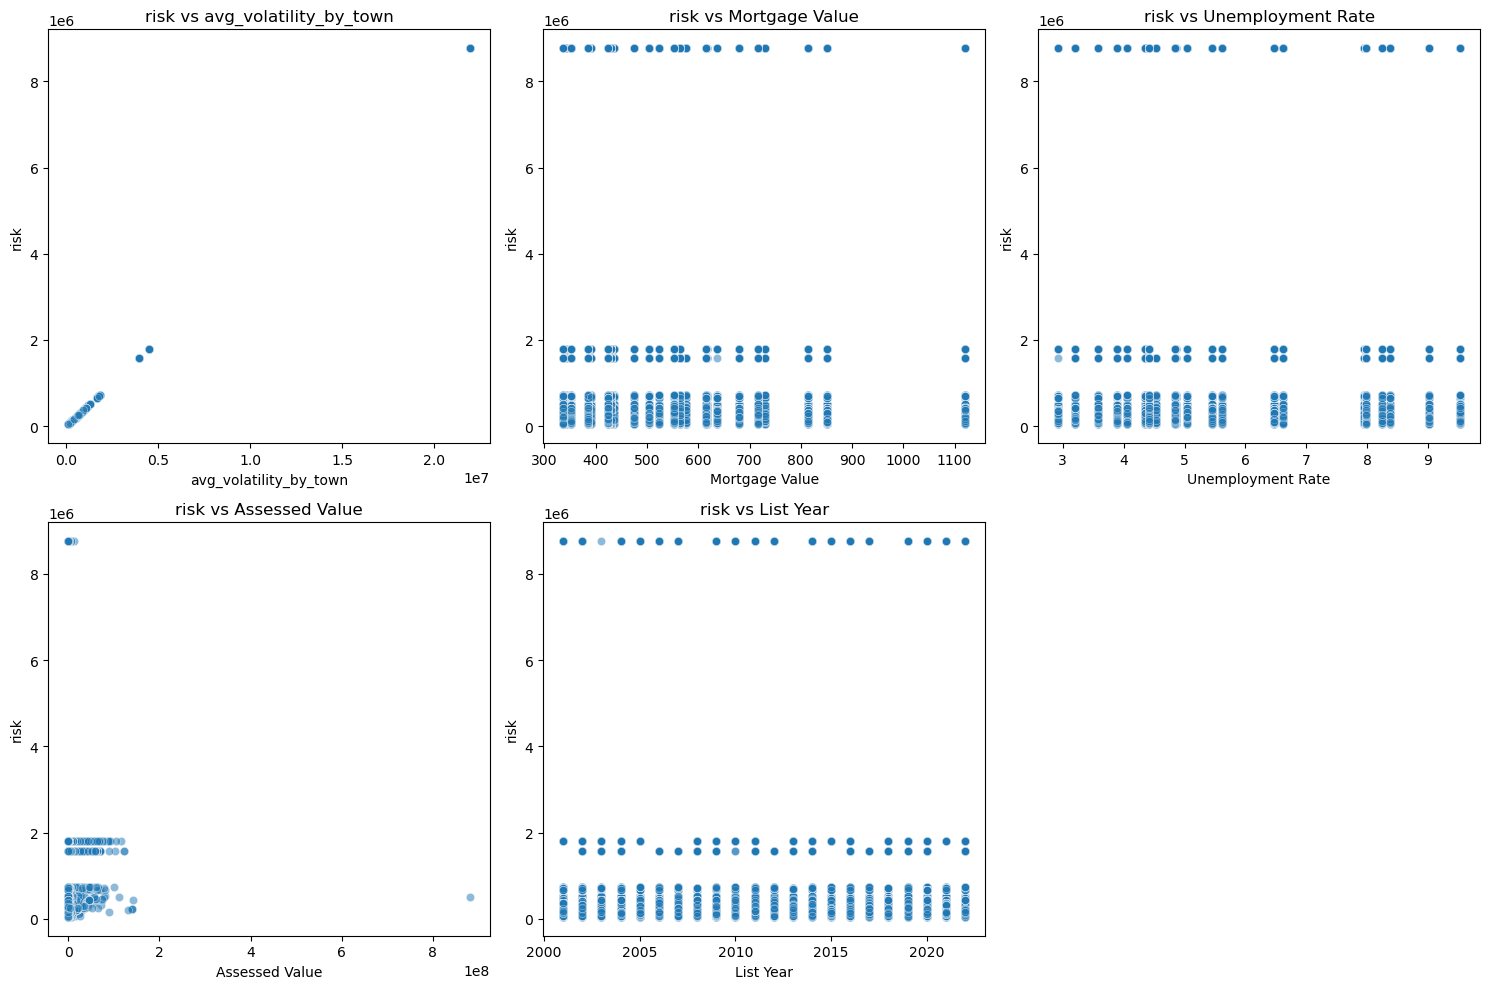

In [13]:
num_vars = ['avg_volatility_by_town', 'Mortgage Value', 'Unemployment Rate', 'Assessed Value', 'List Year']

plt.figure(figsize=(15, 10))

for i, var in enumerate(num_vars):
    plt.subplot(2, 3, i+1)
    sns.scatterplot(data=df_clean, x=var, y='risk_score', alpha=0.5)
    plt.title(f'risk vs {var}')
    plt.xlabel(var)
    plt.ylabel('risk')

plt.tight_layout()
plt.show()

# Prediction

In [18]:
# Step 1 – Create binary target: 1 if 'Risky', 0 otherwise
df_clean['is_risky'] = (df_clean['risk_category'] == 'Risky').astype(int)

# Step 2 – Drop columns that should not be used as features
excluded_cols = [
    'risk_score', 'risk_score_scaled', 'risk_category', 'is_risky',
    'Serial Number', 'Address', 'Transaction Date',
    'Recorded Year', 'Recorded Month', 'Recorded Quarter'
]

features = [col for col in df_clean.columns if col not in excluded_cols]

# Step 3 – Split into features (X) and target (y)
X = df_clean[features]
y = df_clean['is_risky']

# 🧼 Step 4 – Clean data: replace infinities and missing values
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.mean(numeric_only=True))

# Step 5 – Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Step 6 – Identify numeric and categorical columns
num_features = X_train.select_dtypes(include='number').columns.tolist()
cat_features = X_train.select_dtypes(exclude='number').columns.tolist()

# Step 7 – Preprocessing pipeline + XGBoost model
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])

model = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

# Step 8 – Train the model
model.fit(X_train, y_train)

# Step 9 – Predict probabilities on the full dataset
df_clean['predicted_risk_proba'] = model.predict_proba(X)[:, 1]
df_clean['predicted_risk_flag'] = (df_clean['predicted_risk_proba'] > 0.5).astype(int)

# Step 10 – Evaluate on the test set
y_test_pred = model.predict(X_test)
y_test_proba = model.predict_proba(X_test)[:, 1]

print("XGBoost Classification Report (Test Set):")
print(classification_report(y_test, y_test_pred))
print(f"AUC Score: {roc_auc_score(y_test, y_test_proba):.3f}")

C:\Users\eric-\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:49:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Classification Report (Test Set):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    181377
           1       1.00      1.00      1.00     38149

    accuracy                           1.00    219526
   macro avg       1.00      1.00      1.00    219526
weighted avg       1.00      1.00      1.00    219526

AUC Score: 1.000
